In [1]:
# getting the data
import requests
from pathlib import Path
link = 'https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv'
request = requests.get(link)

with open('BostonHousing.csv', 'wb')as f:
  f.write(request.content)

In [17]:
# plot the data
import pandas as pd
data = pd.read_csv(Path('BostonHousing.csv'))
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [18]:
data.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat', 'medv'],
      dtype='object')

In [3]:
# turn it to tensor
import torch
data = torch.tensor(data.values, dtype=torch.float)

In [4]:
min_val = data.min()
max_val = data.max()

# Min-Max normalization
normalized_data = (data - min_val) / (max_val - min_val)

In [5]:
X, y = normalized_data[:, 0:13], normalized_data[:, 13]
X[:3], y[:3]

(tensor([[8.8889e-06, 2.5316e-02, 3.2489e-03, 0.0000e+00, 7.5668e-04, 9.2475e-03,
          9.1702e-02, 5.7525e-03, 1.4065e-03, 4.1632e-01, 2.1519e-02, 5.5823e-01,
          7.0042e-03],
         [3.8411e-05, 0.0000e+00, 9.9437e-03, 0.0000e+00, 6.5963e-04, 9.0309e-03,
          1.1097e-01, 6.9861e-03, 2.8129e-03, 3.4037e-01, 2.5035e-02, 5.5823e-01,
          1.2855e-02],
         [3.8383e-05, 0.0000e+00, 9.9437e-03, 0.0000e+00, 6.5963e-04, 1.0105e-02,
          8.5935e-02, 6.9861e-03, 2.8129e-03, 3.4037e-01, 2.5035e-02, 5.5250e-01,
          5.6681e-03]]),
 tensor([0.0338, 0.0304, 0.0488]))

In [6]:
# split the data
split = int(0.8 * len(X))

X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]
X_train.shape, y_train.shape

(torch.Size([404, 13]), torch.Size([404]))

In [7]:
X_train[0], y_train[0]

(tensor([8.8889e-06, 2.5316e-02, 3.2489e-03, 0.0000e+00, 7.5668e-04, 9.2475e-03,
         9.1702e-02, 5.7525e-03, 1.4065e-03, 4.1632e-01, 2.1519e-02, 5.5823e-01,
         7.0042e-03]),
 tensor(0.0338))

In [160]:
# model
from torch import nn
class modelR(nn.Module):
  def __init__(self, _input, _output, _hidden_layer):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features=_input, out_features=_hidden_layer),
        nn.Linear(in_features=_hidden_layer, out_features=_hidden_layer),
        nn.Linear(in_features=_hidden_layer, out_features=_output)
    )

  def forward(self, x):
    return self.model(x)

model = modelR(X_train.shape[1], 1, 15)
model

modelR(
  (model): Sequential(
    (0): Linear(in_features=13, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=15, bias=True)
    (2): Linear(in_features=15, out_features=1, bias=True)
  )
)

In [161]:
# optimizer loss
loss_fn = nn.MSELoss()
optm = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [162]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [163]:
# train
epochs = 11000

train_losses = []
test_losses = []

for epoch in range(epochs):
  model.train()
  logits = model(X_train).squeeze()
  loss = loss_fn(logits, y_train) ** 0.5
  train_losses.append(loss.item())

  optm.zero_grad()
  loss.backward()
  optm.step()

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_loss = loss_fn(test_logits, y_test) ** 0.5
    test_losses.append(test_loss.item())

  if epoch % 1000 == 0:
    print(f'epoch: {epoch}| train loss: {loss:.5f}| test loss: {test_loss:.5f}')

epoch: 0| train loss: 0.11359| test loss: 0.06266
epoch: 1000| train loss: 0.01213| test loss: 0.00734
epoch: 2000| train loss: 0.01193| test loss: 0.00687
epoch: 3000| train loss: 0.01180| test loss: 0.00660
epoch: 4000| train loss: 0.01170| test loss: 0.00644
epoch: 5000| train loss: 0.01161| test loss: 0.00633
epoch: 6000| train loss: 0.01151| test loss: 0.00626
epoch: 7000| train loss: 0.01142| test loss: 0.00619
epoch: 8000| train loss: 0.01132| test loss: 0.00613
epoch: 9000| train loss: 0.01122| test loss: 0.00607
epoch: 10000| train loss: 0.01111| test loss: 0.00602


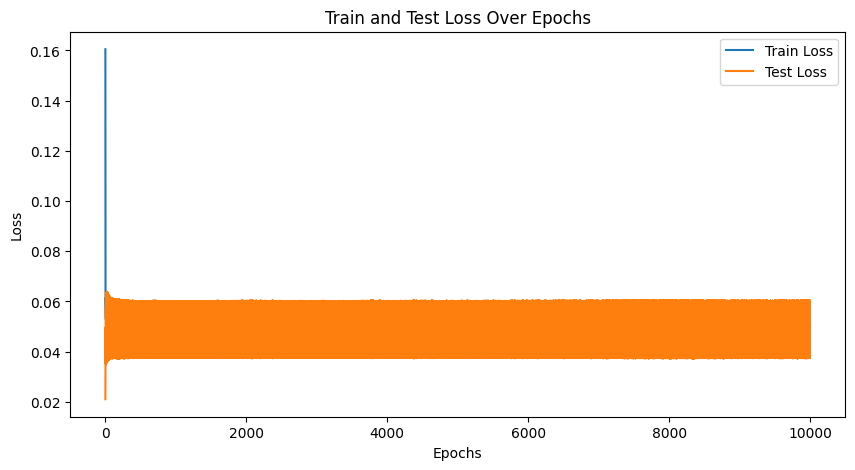

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss Over Epochs')
plt.show()